### Big Query - Agglomerative

2024-06-20 16:42:28,178 - INFO - file_cache is only supported with oauth2client<4.0.0
2024-06-20 16:42:28,442 - INFO - Use pytorch device_name: cpu
2024-06-20 16:42:28,444 - INFO - Load pretrained SentenceTransformer: Alibaba-NLP/gte-base-en-v1.5
C:\Users\dclchan\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-06-20 16:42:31,750 - INFO - Pipeline started.
C:\Users\dclchan\AppData\Local\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
2024-06-20 16:42:35,348 - INFO - Data successfully retrieved from BigQuery.


Batches:   0%|          | 0/124 [00:00<?, ?it/s]

2024-06-20 16:44:02,891 - INFO - Embeddings generated.
2024-06-20 16:44:07,366 - INFO - Header updated in Google Sheet.
2024-06-20 16:44:09,231 - INFO - 15768 cells updated in Google Sheet.
2024-06-20 16:44:09,231 - INFO - DataFrame prepared for Google Sheet update.


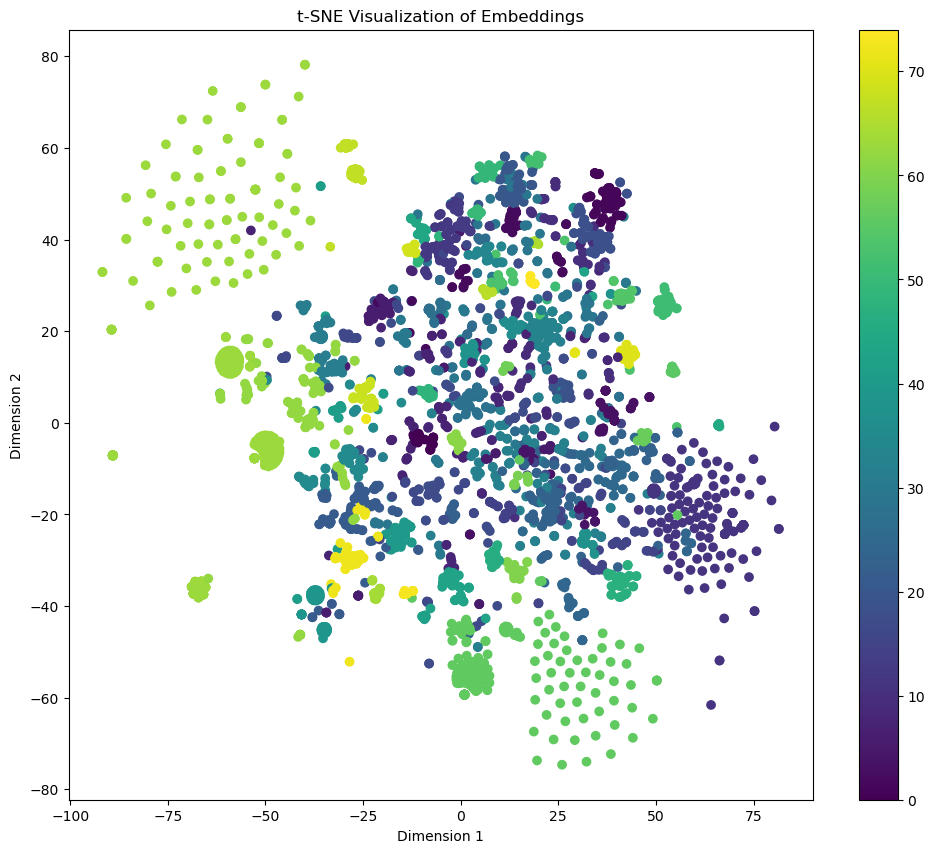

In [195]:
import logging
import os
import re
from typing import Optional

import pandas as pd
from google.cloud import bigquery
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive",
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/bigquery"
]

# Google Sheet IDs
SPREADSHEET_ID = '1gq3blPuyAGbPEqc-VjW78S-J5lAJpDFAvWZo1j4ZuYY'
SHEET_NAME = 'Results'
PROJECT_ID = 'pccw-internal-virtual-agent'

class TextClusteringPipeline:
    def __init__(self, spreadsheet_id: str, sheet_name: str, project_id: str):
        self.spreadsheet_id = spreadsheet_id
        self.sheet_name = sheet_name
        self.project_id = project_id
        self.creds = self.authenticate_google_api()
        self.service = build('sheets', 'v4', credentials=self.creds)
        self.sheet = self.service.spreadsheets()
        self.client = bigquery.Client(credentials=self.creds, project=self.project_id)
        self.model = SentenceTransformer('Alibaba-NLP/gte-base-en-v1.5', trust_remote_code=True)

    def authenticate_google_api(self) -> Optional[Credentials]:
        creds = None
        if os.path.exists('token.json'):
            creds = Credentials.from_authorized_user_file('token.json', SCOPES)
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                try:
                    creds.refresh(Request())
                except Exception as e:
                    logging.error(f"Error refreshing credentials: {e}")
                    return None
            else:
                flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
                creds = flow.run_local_server(port=0)
                with open('token.json', 'w') as token:
                    token.write(creds.to_json())
        return creds

    def get_data_from_bigquery(self, query: str) -> pd.DataFrame:
        try:
            job = self.client.query(query)
            result = job.result().to_dataframe()
            logging.info("Data successfully retrieved from BigQuery.")
            return result
        except Exception as e:
            logging.error(f"Failed to retrieve data from BigQuery: {e}")
            return pd.DataFrame()

    def update_google_sheet(self, data: pd.DataFrame):
        if data.empty:
            logging.error("Received empty DataFrame, aborting Google Sheet update.")
            return
        try:
            header_values = [["Cluster", "Question", "Sentence Count", "Topic"]]
            self.sheet.values().update(
                spreadsheetId=self.spreadsheet_id, range=f'{self.sheet_name}!A1',
                valueInputOption='RAW', body={'values': header_values}
            ).execute()
            logging.info("Header updated in Google Sheet.")

            update_values = data[["Cluster", "Question", "Sentence Count", "Topic"]].values.tolist()
            result = self.sheet.values().update(
                spreadsheetId=self.spreadsheet_id, range=f'{self.sheet_name}!A2',
                valueInputOption='RAW', body={'values': update_values}
            ).execute()
            logging.info(f"{result.get('updatedCells')} cells updated in Google Sheet.")
        except Exception as e:
            logging.error(f"Failed to update Google Sheet: {e}")

    @staticmethod
    def clean_text(text: str) -> str:
        patterns = [
            (r'<@U\w+>', ''),
            (r'[^\w]ticket[\w]id[\w]redacted', 'Ticket Number'),
            (r'(?i)INC\d+', 'Ticket Number'),
            (r'(?i)console connect', ''),
            (r'(?i)wanda', 'Chatbot'),
            (r'(?i)SR\d+', 'Circuit Number')
        ]
        for pattern, replacement in patterns:
            text = re.sub(pattern, replacement, text)
        return text

    def run(self):
        logging.info("Pipeline started.")
        query = """
                SELECT JSON_VALUE(request, '$.queryInput.text.text') AS Request
                FROM `pccw-internal-virtual-agent.prod_wanda_ds.dialogflow_bigquery_export_data`
                ORDER BY conversation_name ASC, request_time ASC
                """
        data = self.get_data_from_bigquery(query)
        if data.empty:
            logging.error("No data retrieved, aborting pipeline.")
            return

        clean_text = [self.clean_text(text) for text in data['Request'].tolist()]

        corpus_embeddings = self.model.encode(clean_text)
        logging.info("Embeddings generated.")
        
        # Perform agglomerative clustering
        clustering_model = AgglomerativeClustering(
            n_clusters=75, distance_threshold=None, linkage='ward'
        ) 
        clustering_model.fit(corpus_embeddings)
        cluster_assignment = clustering_model.labels_
        
        clustered_sentences = {}
        for sentence_id, cluster_id in enumerate(cluster_assignment):
            if cluster_id not in clustered_sentences:
                clustered_sentences[cluster_id] = []
        
            clustered_sentences[cluster_id].append(clean_text[sentence_id])

        # Find the key sentence for each cluster
        key_sentences = {}
        for cluster_id, sentences in clustered_sentences.items():
            cluster_indices = np.where([cluster_assignment[i] == cluster_id for i in range(len(cluster_assignment))])[0]
            cluster_embeddings = corpus_embeddings[cluster_indices]
            cluster_centroid = np.mean(cluster_embeddings, axis=0)
            distances = np.linalg.norm(cluster_embeddings - cluster_centroid, axis=1)
            key_sentence_index = np.argmin(distances)
            key_sentences[cluster_id] = clean_text[cluster_indices[key_sentence_index]]

        # Count the number of sentences in each cluster
        cluster_sentence_counts = {cluster_id: len(sentences) for cluster_id, sentences in clustered_sentences.items()}
        
        data = []
        for cluster_id, sentences in clustered_sentences.items():
            
            for sentence in sentences:
                data.append({
                    "Cluster": cluster_id + 1,
                    "Question": sentence,
                    "Sentence Count": cluster_sentence_counts[cluster_id],
                    "Topic": sentence == key_sentences[cluster_id]
                })
                
        df = pd.DataFrame(data)
        self.update_google_sheet(df.sort_values(by=['Cluster']))
        logging.info("DataFrame prepared for Google Sheet update.")

        tsne = TSNE(n_components=2, random_state=42)
        tsne_embeddings = tsne.fit_transform(corpus_embeddings)
        plt.figure(figsize=(12, 10))
        plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_assignment, cmap='viridis')
        plt.title('t-SNE Visualization of Embeddings')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.colorbar()
        plt.show()


if __name__ == '__main__':
    pipeline = TextClusteringPipeline(SPREADSHEET_ID, SHEET_NAME, PROJECT_ID)
    pipeline.run()

### Test-OPTICS

2024-06-20 17:35:16,890 - INFO - file_cache is only supported with oauth2client<4.0.0
2024-06-20 17:35:17,108 - INFO - Use pytorch device_name: cpu
2024-06-20 17:35:17,109 - INFO - Load pretrained SentenceTransformer: Alibaba-NLP/gte-large-en-v1.5


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\dclchan\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dclchan\.cache\huggingface\hub\models--Alibaba-NLP--gte-large-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


README.md:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

C:\Users\dclchan\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

2024-06-20 17:38:11,897 - INFO - Pipeline started.
C:\Users\dclchan\AppData\Local\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
2024-06-20 17:38:16,166 - INFO - Data successfully retrieved from BigQuery.


Batches:   0%|          | 0/124 [00:00<?, ?it/s]

2024-06-20 17:43:56,214 - INFO - Embeddings generated.


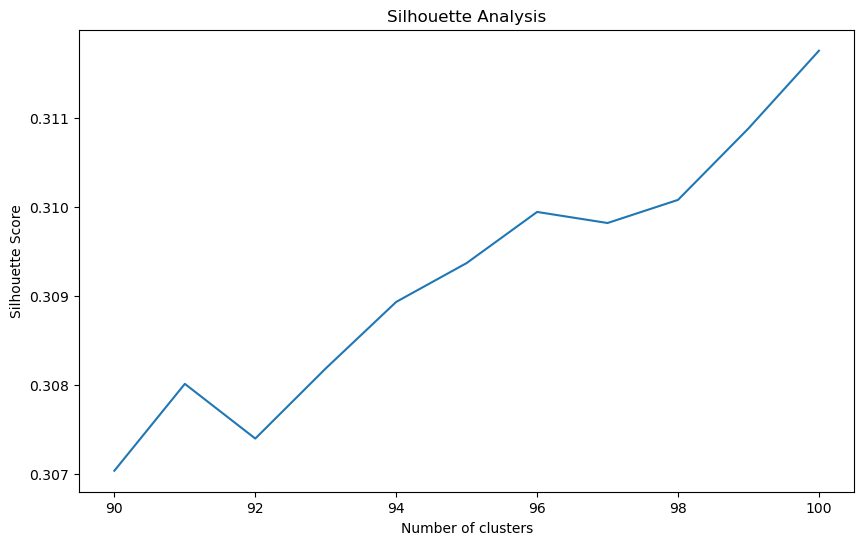

Optimal number of clusters: 100


2024-06-20 17:44:48,813 - INFO - Header updated in Google Sheet.
2024-06-20 17:44:50,095 - INFO - 15768 cells updated in Google Sheet.
2024-06-20 17:44:50,111 - INFO - DataFrame prepared for Google Sheet update.


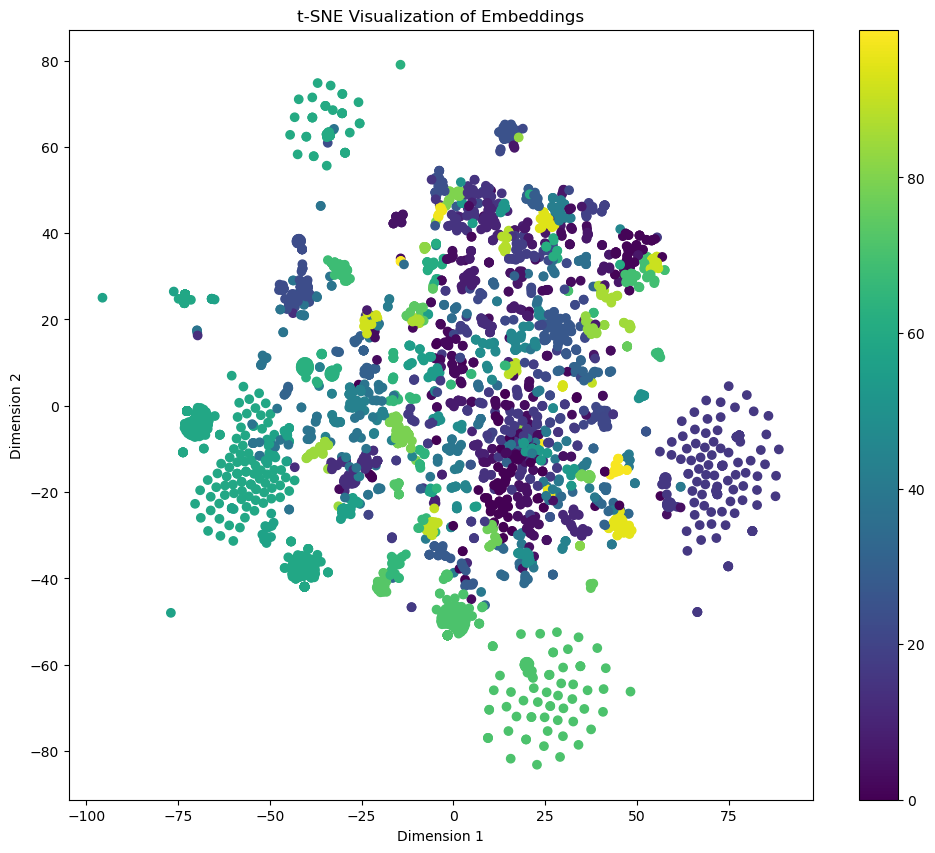

In [209]:
import logging
import os
import re
from typing import Optional

import pandas as pd
from google.cloud import bigquery
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive",
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/bigquery"
]

# Google Sheet IDs
SPREADSHEET_ID = '1gq3blPuyAGbPEqc-VjW78S-J5lAJpDFAvWZo1j4ZuYY'
SHEET_NAME = 'Test'
PROJECT_ID = 'pccw-internal-virtual-agent'

class TextClusteringPipeline:
    def __init__(self, spreadsheet_id: str, sheet_name: str, project_id: str):
        self.spreadsheet_id = spreadsheet_id
        self.sheet_name = sheet_name
        self.project_id = project_id
        self.creds = self.authenticate_google_api()
        self.service = build('sheets', 'v4', credentials=self.creds)
        self.sheet = self.service.spreadsheets()
        self.client = bigquery.Client(credentials=self.creds, project=self.project_id)
        self.model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)

    def authenticate_google_api(self) -> Optional[Credentials]:
        creds = None
        if os.path.exists('token.json'):
            creds = Credentials.from_authorized_user_file('token.json', SCOPES)
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                try:
                    creds.refresh(Request())
                except Exception as e:
                    logging.error(f"Error refreshing credentials: {e}")
                    return None
            else:
                flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
                creds = flow.run_local_server(port=0)
                with open('token.json', 'w') as token:
                    token.write(creds.to_json())
        return creds

    def get_data_from_bigquery(self, query: str) -> pd.DataFrame:
        try:
            job = self.client.query(query)
            result = job.result().to_dataframe()
            logging.info("Data successfully retrieved from BigQuery.")
            return result
        except Exception as e:
            logging.error(f"Failed to retrieve data from BigQuery: {e}")
            return pd.DataFrame()

    def update_google_sheet(self, data: pd.DataFrame):
        if data.empty:
            logging.error("Received empty DataFrame, aborting Google Sheet update.")
            return
        try:
            header_values = [["Cluster", "Question", "Sentence Count", "Topic"]]
            self.sheet.values().update(
                spreadsheetId=self.spreadsheet_id, range=f'{self.sheet_name}!A1',
                valueInputOption='RAW', body={'values': header_values}
            ).execute()
            logging.info("Header updated in Google Sheet.")

            update_values = data[["Cluster", "Question", "Sentence Count", "Topic"]].values.tolist()
            result = self.sheet.values().update(
                spreadsheetId=self.spreadsheet_id, range=f'{self.sheet_name}!A2',
                valueInputOption='RAW', body={'values': update_values}
            ).execute()
            logging.info(f"{result.get('updatedCells')} cells updated in Google Sheet.")
        except Exception as e:
            logging.error(f"Failed to update Google Sheet: {e}")

    @staticmethod
    def clean_text(text: str) -> str:
        patterns = [
            (r'<@U\w+>', ''),
            (r'[^\w]ticket[\w]id[\w]redacted', 'Ticket Number'),
            (r'(?i)INC\d+', 'Ticket Number'),
            (r'(?i)console connect', ''),
            (r'(?i)wanda', 'Chatbot'),
            (r'(?i)SR\d+', 'Circuit Number')
        ]
        for pattern, replacement in patterns:
            text = re.sub(pattern, replacement, text)
        return text

    def determine_optimal_clusters(self, corpus_embeddings, min_clusters: int, max_clusters: int):
        silhouette_scores = []
        for n_clusters in range(min_clusters, max_clusters+1):
            clustering_model = AgglomerativeClustering(
                n_clusters=n_clusters, distance_threshold=None, linkage='ward'
            )
            cluster_labels = clustering_model.fit_predict(corpus_embeddings)
            silhouette_score_value = silhouette_score(corpus_embeddings, cluster_labels)
            silhouette_scores.append(silhouette_score_value)
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(min_clusters, max_clusters+1), silhouette_scores)
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Analysis')
        plt.show()
        
        # Determine the optimal number of clusters based on the maximum silhouette score
        optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + min_clusters
        return optimal_clusters

    def run(self):
        logging.info("Pipeline started.")
        query = """
                SELECT JSON_VALUE(request, '$.queryInput.text.text') AS Request
                FROM `pccw-internal-virtual-agent.prod_wanda_ds.dialogflow_bigquery_export_data`
                ORDER BY conversation_name ASC, request_time ASC
                """
        data = self.get_data_from_bigquery(query)
        if data.empty:
            logging.error("No data retrieved, aborting pipeline.")
            return

        clean_text = [self.clean_text(text) for text in data['Request'].tolist()]

        corpus_embeddings = self.model.encode(clean_text)
        logging.info("Embeddings generated.")

        # determine_optimal_clusters
        optimal_clusters = self.determine_optimal_clusters(corpus_embeddings, 90, 100)
        print(f"Optimal number of clusters: {optimal_clusters}")
        
        # Update the clustering model with the optimal number of clusters
        clustering_model = AgglomerativeClustering(
            n_clusters=optimal_clusters, distance_threshold=None, linkage='ward'
        )
        clustering_model.fit(corpus_embeddings)
        cluster_assignment = clustering_model.labels_
        
        clustered_sentences = {}
        for sentence_id, cluster_id in enumerate(cluster_assignment):
            if cluster_id not in clustered_sentences:
                clustered_sentences[cluster_id] = []
        
            clustered_sentences[cluster_id].append(clean_text[sentence_id])

        # Find the key sentence for each cluster
        key_sentences = {}
        for cluster_id in range(clustering_model.n_clusters_):
            cluster_indices = np.where([cluster_assignment[i] == cluster_id for i in range(len(cluster_assignment))])[0]
            cluster_embeddings = corpus_embeddings[cluster_indices]
            cluster_centroid = np.mean(cluster_embeddings, axis=0)
            distances = np.linalg.norm(cluster_embeddings - cluster_centroid, axis=1)
            key_sentence_index = np.argmin(distances)
            key_sentences[cluster_id] = clean_text[cluster_indices[key_sentence_index]]

        # Count the number of sentences in each cluster
        cluster_sentence_counts = {cluster_id: len(sentences) for cluster_id, sentences in clustered_sentences.items()}
        
        data = []
        for cluster_id, sentences in clustered_sentences.items():
            
            for sentence in sentences:
                data.append({
                    "Cluster": cluster_id + 1,
                    "Question": sentence,
                    "Sentence Count": cluster_sentence_counts[cluster_id],
                    "Topic": sentence == key_sentences[cluster_id]
                })
                
        df = pd.DataFrame(data)
        self.update_google_sheet(df.sort_values(by=['Cluster']))
        logging.info("DataFrame prepared for Google Sheet update.")

        tsne = TSNE(n_components=2, random_state=42)
        tsne_embeddings = tsne.fit_transform(corpus_embeddings)
        plt.figure(figsize=(12, 10))
        plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_assignment, cmap='viridis')
        plt.title('t-SNE Visualization of Embeddings')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.colorbar()
        plt.show()


if __name__ == '__main__':
    pipeline = TextClusteringPipeline(SPREADSHEET_ID, SHEET_NAME, PROJECT_ID)
    pipeline.run()

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import AgglomerativeClustering
from queue import PriorityQueue
from multiprocessing import Pool
from sentence_transformers import SentenceTransformer

# Load the pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
model2 = SentenceTransformer('all-mpnet-base-v2')

def sentence_to_embedding(sentence, expensive=False):
    if expensive:
        # Use a more expensive, higher-quality model for strong similarity
        embedding = model2.encode([sentence], convert_to_tensor=True)[0]
    else:
        # Use a cheaper, lower-quality model for weak similarity
        embedding = model.encode([sentence], convert_to_tensor=False)[0]
    return embedding

def weak_similarity_fn(sentence1, sentence2):
    embedding1 = sentence_to_embedding(sentence1)
    embedding2 = sentence_to_embedding(sentence2)
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

def strong_similarity_fn(sentence1, sentence2):
    embedding1 = sentence_to_embedding(sentence1, expensive=True)
    embedding2 = sentence_to_embedding(sentence2, expensive=True)
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

def compute_weak_similarities(sentences):
    n = len(sentences)
    row, col, data = [], [], []
    for i in range(n):
        for j in range(i+1, n):
            similarity = weak_similarity_fn(sentences[i], sentences[j])
            if similarity > 0:
                row.append(i)
                col.append(j)
                data.append(similarity)
    return csr_matrix((data, (row, col)), shape=(n, n))

def kwikbucks_cluster(sentences, budget):
    n = len(sentences)
    
    # Compute weak similarities using multiprocessing
    with Pool() as pool:
        weak_similarities = compute_weak_similarities(sentences)
    
    # Convert sparse matrix to dense numpy array
    weak_similarities = weak_similarities.toarray()
    
    # Initialize clusters using single-linkage clustering based on weak similarities
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, linkage='single')
    clustering.fit(weak_similarities)
    
    # Merge clusters based on strong similarities, respecting the query budget
    linkage_matrix = clustering.linkage_
    labels = np.arange(n)
    
    pq = PriorityQueue()
    for i in range(n):
        for j in range(i+1, n):
            if weak_similarities[i, j] > 0:
                pq.put((-weak_similarities[i, j], i, j))
    
    queries = 0
    while queries < budget:
        # Find the pair of clusters with the highest weak similarity
        _, i, j = pq.get()
        
        # Query the strong oracle for the most promising cluster pair
        if strong_similarity_fn(sentences[i], sentences[j]) > 0.5:
            # Merge clusters based on the linkage matrix
            min_label = min(labels[i], labels[j])
            max_label = max(labels[i], labels[j])
            linkage_matrix[linkage_matrix[:, 0] == max_label, 0] = min_label
            linkage_matrix[linkage_matrix[:, 1] == max_label, 1] = min_label
            labels[labels == max_label] = min_label
        else:
            break
        
        queries += 1
    
    # Assign final cluster labels
    final_labels = np.unique(labels, return_inverse=True)[1]
    
    # Print the sentences and their cluster labels
    for sentence, label in zip(sentences, final_labels):
        print(f"Sentence: {sentence}")
        print(f"Cluster Label: {label}")
        print()
    
    return final_labels

# Example usage
sentences = [
    "Ticket Number",
    "hi Chatbot",
    "hi",
    "remedy ticket id is Ticket Number",
    "can you summarize Ticket Number",
    "show the details of the ticket Ticket Number?",
    "i have question",
    "Please summarize for me the remedy ticket ID Ticket Number",
    "Can you generate a summary for Ticket Number?",
    "what is cloudrouter?",
    "can you summarize this remedy ticket?",
    "how much is a 10g port in singapore?",
    "what can Chatbot do>",
    "check status Ticket Number",
    "EP43509",
    "What is",
    "Please share note from remedy ticket id",
    "please check Ticket Number",
    "can you please check the status of this remedy ticket?",
    "Tell me about Cloud Router",
    "How does a customer open a fault repair request for a service?",
    "can you check remedy ticket status?",
    "Console services",
    "how to reset insight password?",
    "who is managing Company?",
    "how to troubleshoot cloud router service?"
]

labels = kwikbucks_cluster(sentences, budget=100)

2024-06-20 18:07:39,471 - INFO - Use pytorch device_name: cpu
2024-06-20 18:07:39,471 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
C:\Users\dclchan\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-06-20 18:07:42,337 - INFO - Use pytorch device_name: cpu
2024-06-20 18:07:42,338 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]